## УСЛОВИЕ:
Обучаемся на данных **train.csv**, а валидируемся на **test.csv**.

Необходимо обучить нейронную сеть определять цифру на изображении по заданному вектору.

In [30]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# import torchvision.transforms as transforms
# import torchvision.datasets as dsets
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# device = torch.device('cpu')

In [32]:
df = pd.read_csv('train.csv')

In [33]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Создадим класс, в объекты которого будем загружать данные из .csv файлов

In [34]:
class MyDataset(Dataset):
    def __init__(self, X, y=None):
        self.n_samples = X.shape[0]
        self.x_data = torch.from_numpy(X / 255 * 0.99 + 0.01).type(torch.float)
        if not y is None:
            self.y_data = torch.from_numpy(y)
        else:
            self.y_data = torch.zeros(self.n_samples)

    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.n_samples

In [35]:
X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()

In [36]:
batch_size = 100
n_iters = 100000

In [37]:
# Класс - модуль, реализующий архитектуру. Можно было бы использовать nn.Sequential
class FeedforwardNeuralNetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Первый полносвязный слой
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim, device=device) 

        # Нелинейная функция
        self.activation = torch.nn.ReLU()
        
        # Полносвязный слой
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim, device=device)  

    def forward(self, x):
        # Полносвязный слой
        out = self.fc1(x)

        # Нелинейная функция
        out = self.activation(out)

        # Полносвязный слой
        out = self.fc2(out)
        return out

In [38]:
input_dim = 28*28
hidden_dim = 200
output_dim = 10

In [39]:
criterion = torch.nn.CrossEntropyLoss()

In [40]:
learning_rate = 0.1

In [44]:
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

Я запустил обучение модели 3 раза, каждый раз по новой разбивая датасет на train и test

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

# Передаем параметры в оптимизатор, чтобы для них считались градиенты
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Спрямляем изображение в вектор
        images = images.view(-1, 28*28)
        images = images.cuda(device)
        labels = labels.cuda(device)

        # Затираем прошлые градиенты, чтобы они не аккумулировались
        optimizer.zero_grad()

        # Получаем выход модели
        outputs = model(images)

        # Вычисляем значение функции потерь
        loss = criterion(outputs, labels)
        
        # Здесь происходит вычисление градентов для параметров модели, которые переданы в оптимизатор
        loss.backward()

        # Здесь происходит обновление параметров
        optimizer.step()

        iteration += 1

        if iteration % 10000 == 0:
            # Вычисляем точность (можно пользоваться и sklearn)         
            correct = 0
            total = 0
            # Итерация по всему валидационному датасету, "переключаем" модель в режим инференса
            # (в данном случае не обязательно, но в общем случае важно не забывать)
            model.eval()
            # Поскольку нам не нужно вычисление градиентов, мы используем менеджер контекста
            with torch.no_grad():
                for images, labels in test_loader:
                    # Преобразуем изображение в вектор
                    images = images.view(-1, 28*28)
                    
                    images = images.cuda(device)
                    labels = labels.cuda(device)
                    
                    # Получаем выход модели
                    outputs = model(images)


                    # Берем класс, имеющий наибольшую вероятность (здесь логиты)
                    _, predicted = torch.max(outputs.data, 1)

                    # Подсчитываем общее количество объектов в тестовой выборке
                    total += labels.size(0)

                    # Общее количество верно классифицированных объектов
                    correct += (predicted == labels).sum()
                model.train()
            accuracy = 100 * correct / total
            
            print('Итерация: {}. Validation loss: {}. Validation accuracy: {}'.format(iteration, loss.item(), accuracy))

Итерация: 10000. Validation loss: 0.00042739309719763696. Validation accuracy: 99.81904602050781
Итерация: 20000. Validation loss: 0.0014987312024459243. Validation accuracy: 99.81904602050781
Итерация: 30000. Validation loss: 0.0001441744971089065. Validation accuracy: 99.80952453613281
Итерация: 40000. Validation loss: 0.00078673503594473. Validation accuracy: 99.79047393798828
Итерация: 50000. Validation loss: 0.0003526598447933793. Validation accuracy: 99.79047393798828
Итерация: 60000. Validation loss: 0.0007162599358707666. Validation accuracy: 99.78095245361328
Итерация: 70000. Validation loss: 0.0002267352829221636. Validation accuracy: 99.77143096923828
Итерация: 80000. Validation loss: 0.00018339732196182013. Validation accuracy: 99.77143096923828
Итерация: 90000. Validation loss: 0.00022876044386066496. Validation accuracy: 99.77143096923828


Загрузим валидационный датасет

In [48]:
validation_df = pd.read_csv('test.csv')
validation_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Сгенерируем ответы обученной модели на данных из файла test.csv

In [51]:
X_validation = validation_df.values
validation_dataset = MyDataset(X_validation)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                          batch_size=len(validation_dataset), 
                                          shuffle=False)

for images, _ in validation_loader:
    images = images.cuda(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

Объединим в один набор ответы модели и валидационные данные

In [52]:
data = np.hstack((predicted.cpu().numpy().reshape(-1, 1), X_validation))

Запуская ячейку можно визуально проверить качество модели

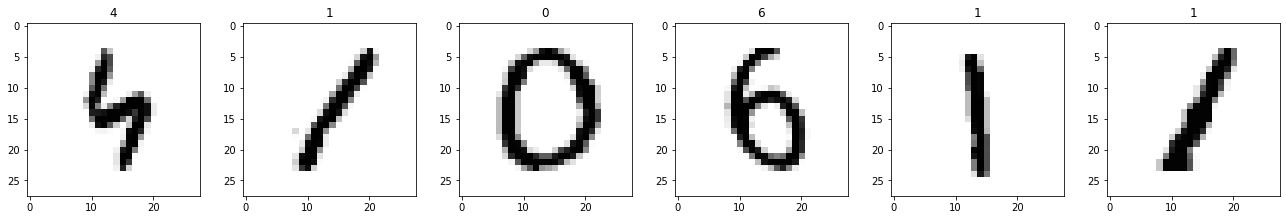

In [113]:
index_array = np.random.choice(range(data.shape[0]), 6, replace=False)

fig = plt.figure(figsize=(10, 8))
for i, idx in enumerate(index_array):
    image_array = data[idx][1:].reshape(28, 28)
    label = data[idx][0]
    ax = fig.add_axes([0.3*i, 1, 0.30, 0.30])
    ax.imshow(image_array, cmap='Greys', interpolation='None')
    ax.set_title(label);